In [1]:
import os
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten
os.environ["OMP_NUM_THREADS"] = "4"



In [6]:

# Load stock price data
# Example: using Yahoo Finance API to fetch data
# Replace the code below with your preferred method of loading stock data
import yfinance as yf
#stock_data = yf.download('APPL', start='2020-01-01', end='2024-01-01')
#stock_data = yf.download('MSFT', start='2020-01-01', end='2024-01-01')
stock_data = yf.download('AMZN', start='2015-01-01', end='2024-01-01')

[*********************100%%**********************]  1 of 1 completed


In [10]:
stock_data.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999736,0.999681,0.999352,0.999352,-0.069155
High,0.999736,1.000000,0.999615,0.999696,0.999696,-0.063295
Low,0.999681,0.999615,1.000000,0.999712,0.999712,-0.077458
Close,0.999352,0.999696,0.999712,1.000000,1.000000,-0.070595
Adj Close,0.999352,0.999696,0.999712,1.000000,1.000000,-0.070595
Volume,-0.069155,-0.063295,-0.077458,-0.070595,-0.070595,1.000000


In [11]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,15.629000,15.737500,15.348000,15.426000,15.426000,55664000
2015-01-05,15.350500,15.419000,15.042500,15.109500,15.109500,55484000
2015-01-06,15.112000,15.150000,14.619000,14.764500,14.764500,70380000
2015-01-07,14.875000,15.064000,14.766500,14.921000,14.921000,52806000
2015-01-08,15.016000,15.157000,14.805500,15.023000,15.023000,61768000
...,...,...,...,...,...,...
2023-12-22,153.770004,154.350006,152.710007,153.419998,153.419998,29480100
2023-12-26,153.559998,153.979996,153.029999,153.410004,153.410004,25067200
2023-12-27,153.559998,154.779999,153.119995,153.339996,153.339996,31434700


In [13]:

# Extract closing prices
closing_prices = stock_data['Close'].values.reshape(-1, 1)


In [15]:
type(closing_prices)

numpy.ndarray

In [31]:

# Normalize closing prices
scaler = MinMaxScaler(feature_range=(0, 1))
closing_prices_scaled = scaler.fit_transform(closing_prices)


In [33]:

# Train Hidden Markov Model (HMM)
hmm_model = GaussianHMM(n_components=2, covariance_type="full")
hmm_model.fit(closing_prices_scaled)

c:\Users\stefa\anaconda3\envs\py3aai\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


GaussianHMM(covariance_type='full', n_components=2)

In [34]:


# Predict hidden states
hidden_states = hmm_model.predict(closing_prices_scaled)


In [35]:

# LSTM Model altenavive
def create_LSTM_model_with_conv(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(LSTM(units=50, return_sequences=True))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [36]:


# Prepare data for LSTM
def prepare_LSTM_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps - 1):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

In [37]:

# Define parameters
time_steps = 30


In [38]:

# Prepare data for LSTM
X_lstm, y_lstm = prepare_LSTM_data(closing_prices_scaled, time_steps)


In [39]:

# Reshape data for LSTM
X_lstm = np.reshape(X_lstm, (X_lstm.shape[0], X_lstm.shape[1], 1))


In [55]:

# Create LSTM model
lstm_model = create_LSTM_model((X_lstm.shape[1], 1))


In [57]:

# Train LSTM model
lstm_model.fit(X_lstm, y_lstm, epochs=600, batch_size=64)


Epoch 1/600
16/16 [==============================] - 4s 29ms/step - loss: 0.0945
Epoch 2/600
16/16 [==============================] - 0s 24ms/step - loss: 0.0101
Epoch 3/600
16/16 [==============================] - 0s 22ms/step - loss: 0.0053
Epoch 4/600
16/16 [==============================] - 0s 22ms/step - loss: 0.0028
Epoch 5/600
16/16 [==============================] - 0s 22ms/step - loss: 0.0020
Epoch 6/600
16/16 [==============================] - 0s 22ms/step - loss: 0.0017
Epoch 7/600
16/16 [==============================] - 0s 23ms/step - loss: 0.0016
Epoch 8/600
16/16 [==============================] - 0s 24ms/step - loss: 0.0016
Epoch 9/600
16/16 [==============================] - 0s 22ms/step - loss: 0.0016
Epoch 10/600
16/16 [==============================] - 0s 22ms/step - loss: 0.0016
Epoch 11/600
16/16 [==============================] - 0s 26ms/step - loss: 0.0015
Epoch 12/600
16/16 [==============================] - 0s 21ms/step - loss: 0.0015
Epoch 13/600
16/16 [=====

In [61]:

# Predict next day's closing price
latest_prices_scaled = closing_prices_scaled[-time_steps:]
latest_prices_scaled = np.reshape(latest_prices_scaled, (1, latest_prices_scaled.shape[0], 1))
predicted_price_scaled = lstm_model.predict(latest_prices_scaled)
predicted_price = scaler.inverse_transform(predicted_price_scaled)

print("Predicted next day's closing price (LSTM):", predicted_price[0][0])


1/1 [==============================] - 2s 2s/step
Predicted next day's closing price (LSTM): 374.45322


In [43]:

# Predict next day's closing price using HMM
last_observed_price_scaled = closing_prices_scaled[-1].reshape(1, -1)
next_hidden_state = hmm_model.predict(last_observed_price_scaled)[0]
next_observation = hmm_model.means_[next_hidden_state]
predicted_price_hmm = scaler.inverse_transform(next_observation.reshape(-1, 1))

print("Predicted next day's closing price (HMM):", predicted_price_hmm[0][0])


Predicted next day's closing price (HMM): 223.13979511210098


In [44]:
import matplotlib.pyplot as plt

# Plot actual vs. predicted prices
def plot_predictions(actual, predicted, title):
    plt.figure(figsize=(10, 6))
    plt.plot(actual, label='Actual Prices', color='blue')
    plt.plot(predicted, label='Predicted Prices', color='red')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


31/31 [==============================] - 0s 10ms/step


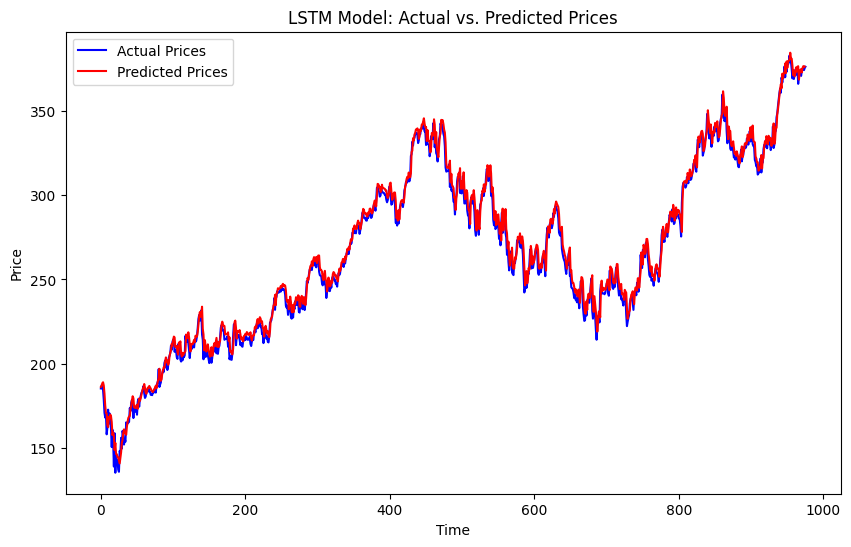

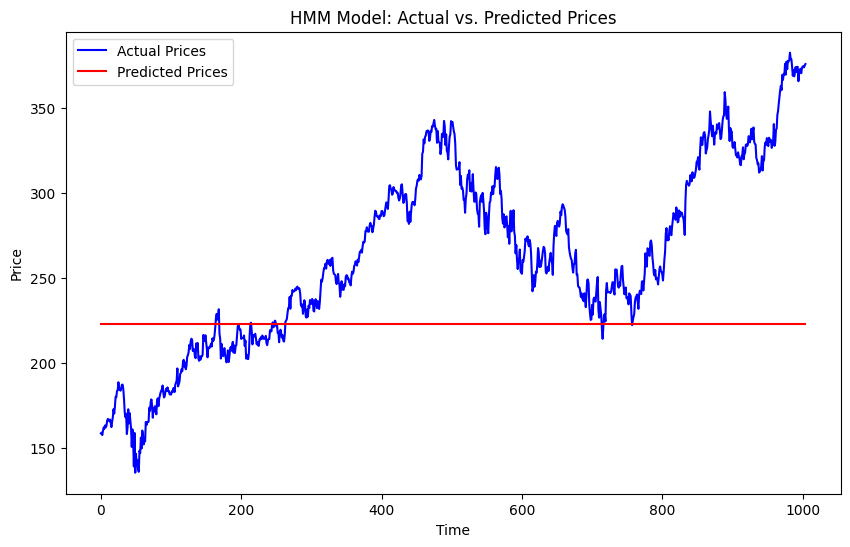

In [45]:


# Plot actual vs. predicted prices for LSTM model
predicted_prices_lstm_scaled = lstm_model.predict(X_lstm)
predicted_prices_lstm = scaler.inverse_transform(predicted_prices_lstm_scaled)

plot_predictions(closing_prices[time_steps:], predicted_prices_lstm,
                 "LSTM Model: Actual vs. Predicted Prices")

# Plot actual vs. predicted prices for HMM model
predicted_prices_hmm = []
for i in range(len(closing_prices_scaled) - 1):
    observed_price_scaled = closing_prices_scaled[i].reshape(1, -1)
    next_hidden_state = hmm_model.predict(observed_price_scaled)[0]
    next_observation = hmm_model.means_[next_hidden_state]
    predicted_price_hmm = scaler.inverse_transform(
        next_observation.reshape(-1, 1))
    predicted_prices_hmm.append(predicted_price_hmm[0][0])

plot_predictions(closing_prices[1:], predicted_prices_hmm,
                 "HMM Model: Actual vs. Predicted Prices")